# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [1]:
# Importing Libraries
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Setting environment variables for kaggle API
os.environ['KAGGLE_USERNAME'] = 'subzeronewbie'
os.environ['KAGGLE_KEY'] = 'f864bac9af8ca6a8d351b9e375bd5e49'

# class <code>FruitFeatureExtractor</code>
<b>Attributes:</b>

1.<code>canny_low</code>: Hysteresis low threshold used during Canny edge detection

2.<code>canny_high</code>: Hysteresis high threshold used during Canny edge detection

3.<code>bg_threshold</code>: Intensity threshold used to separate the fruit from the white background

<br>
<b>Methods:</b>

1.<code>get_lbp_image(gray)</code> Outputs LBP image of gray_img

2.<code>get_canny_image(gray_img)</code> Returns cv2 Canny edge image of gray_img

3.<code>get_color_features(img_bgr)</code> Outputs a list of colour features of img_bgr

4.<code>get_shape_features(img_bgr)</code> Outputs a list of shape features given of img_bgr

In [2]:
# --- 1.Feature Extractor Utility ---
class FruitFeatureExtractor:
    """
    Helper class to handle all image processing and feature extraction.
    """
    def __init__(self):
        # Configuration for Canny
        self.canny_low = 100
        self.canny_high = 200

        # Configuration for colour (shape) processing
        self.bg_threshold = 240 # Background is white (255)


    def get_lbp_image (self, gray):
        """
        Outputs LBP image of input gray image
        """
        h, w = gray.shape
        lbp = np.zeros((h-2, w-2), dtype=np.uint8)
        for i in range(1, h-1): 
            for j in range (1, w-1):
                c = gray[i, j]
                code = 0
                code |= (gray[i-1, j-1] >= c) << 7 
                code |= (gray[i-1, j] >= c) << 6
                code |= (gray[i-1, j+1] >= c) << 5
                code |= (gray[i , j+1] >= c) << 4
                code |= (gray[i+1, j+1] >= c) << 3
                code |= (gray[i+1, j ] >= c) << 2
                code |= (gray[i+1, j-1] >= c) << 1
                code |= (gray[i , j-1] >= c) << 0
                lbp [i-1, j-1] = code
        
        return lbp

    def get_canny_image(self, gray_img):
        """Returns cv2 Canny edge image of input gray image"""
        return cv2.Canny(gray_img, self.canny_low, self.canny_high)

    def get_color_features(self, img_bgr):
        """
        Outputs a list of the following colour features given an input colour image
        1. Mean Hue          
        2. StdDev Hue
        3. Mean Saturation   
        4. StdDev Saturation
        5. Mean Value        
        6. StdDev Value
        """
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

        # meanStdDev computes mean and std for all 3 channels at once
        mean, std = cv2.meanStdDev(hsv)
        
        # Returns a flat array of the form: [H_mean, S_mean, V_mean, H_std, S_std, V_std]
        features = np.array([
            mean[0][0], std[0][0],  # Hue
            mean[1][0], std[1][0],  # Saturation
            mean[2][0], std[2][0]   # Value
        ], dtype=np.float32)
        
        return features
    
    def get_shape_features(self, img_bgr):
        """
        Outputs a list of the following shape features given an input colour image
        1.Area Ratio 
        2.Aspect Ratio
        3.Solidity
        4.Circularity
        5.Hu Moment 1
        6.Hu Moment 2
        """
        # 1. Creates a Binary mask that rejects any pixel in the gray image with brightness > self.bg_threshold i.e. rejects the white background
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, self.bg_threshold, 255, cv2.THRESH_BINARY_INV)

        # 2. Finds Largest Contour
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
        if not contours:
            return np.zeros(6, dtype=np.float32) # Handles possible errors if no contour is found
            
        cnt = max(contours, key=cv2.contourArea)
        
        # Finds basic Measurements of area and perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: perimeter = 1.0 # Avoids division by zero
        
        _, _, w, h = cv2.boundingRect(cnt)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        if hull_area == 0: hull_area = 1.0 # Avoids division by zero
        
        total_image_area = img_bgr.shape[0] * img_bgr.shape[1]

        # 1. Area Ratio
        area_ratio = area / total_image_area
        
        # 2. Aspect Ratio (w / h)
        aspect_ratio = float(w) / h if h != 0 else 0
        
        # 3. Solidity (Area / Convex Hull Area)
        solidity = area / hull_area
        
        # 4. Circularity (4 * pi * Area / P^2)
        circularity = (4 * np.pi * area) / (perimeter ** 2)

        # --- Hu Moments ---
        moments = cv2.moments(cnt)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log scale transform defn: -sign(h) * log10(abs(h))
        # Avoids errors with -ve numbers
        def log_transform(m):
            return -1 * np.sign(m) * np.log10(np.abs(m)) if m != 0 else 0
            
        phi1 = log_transform(hu_moments[0])
        phi2 = log_transform(hu_moments[1])

        return np.array([area_ratio, aspect_ratio, solidity, circularity, phi1, phi2], dtype=np.float32)

# class <code>FruitsDataset</code>
<b>Attributes:</b>

1.<code>root_dir</code>: Path to the dataset folder

2.<code>classes</code>: Sorted list of class names (folders) inside the dataset. Eg: Apple 1, Ginger Root 1

3.<code>class_map</code>: Dictionary mapping class names to integer indices

4.<code>image_paths</code>: List of absolute paths to all images

5.<code>labels</code>: List of target labels corresponding to <code>image_paths</code>

6.<code>processor</code>: Instance of <code>FruitFeatureExtractor</code> used for image processing


<br>
<b>Methods:</b>

1.<code>__getitem__</code> returns a dictionary with the following keys:

i. 'image': The RGB image tensor(for CNN processing)

ii. 'lbp': The LBP texture image tensor(1-channel)

iii. 'canny': The Edge detection image tensor(1-channel)

iv. 'features': A dictionary of size 12 (6 Color + 6 Shape features)
<ol>
    <li>Mean Hue</li>          
    <li>StdDev Hue</li>
    <li>Mean Saturation</li>   
    <li>StdDev Saturation</li>
    <li>Mean Value</li>        
    <li>StdDev Value</li>
    <li>Area Ratio</li> 
    <li>Aspect Ratio</li>
    <li>Solidity</li>
    <li>Circularity</li>
    <li>Hu Moment 1</li>
    <li>Hu Moment 2</li>
</ol>
v. 'label': The class index

2.<code>download_dataset</code> Downloads the Fruits-360 dataset from Kaggle if not present

3.<code>len</code> Returns the total number of images in the dataset

In [3]:
# --- 2.Dataset Class ---
class FruitsDataset(Dataset):
    def __init__(self, root_dir, download=False):
        self.root_dir = root_dir
        if download:
            self.download_dataset()

        self.classes = sorted(os.listdir(self.root_dir))
        self.class_map = {cls: i for i, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        # Initializes the processor
        self.processor = FruitFeatureExtractor()
        
        # Loads file paths
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            if os.path.isdir(cls_path):
                for img in os.listdir(cls_path):
                    if img.lower().endswith(('.jpg', '.png')):
                        self.image_paths.append(os.path.join(cls_path, img))
                        self.labels.append(self.class_map[cls])

    def download_dataset(self):
        # Checks if the main 'fruits-360' folder exists in the current directory
        if os.path.exists("fruits-360_100x100/fruits-360"):
            print("Files already exist. Skipping download.\n")
            return
        
        # Else downloads
        print("Downloading Fruits-360 from Kaggle...")
        import kaggle
        
        # Downloads to current folder
        kaggle.api.dataset_download_files('moltean/fruits', path='.', unzip=True)
        print("Download complete.\n")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Loads Image at idx
        img_path = self.image_paths[idx]
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

        # 2. Calculates the LBP and canny image
        lbp_img = self.processor.get_lbp_image(img_gray)
        canny_img = self.processor.get_canny_image(img_gray)

        # 3. Extracts 6 colour + 6 shape features
        color_feats = self.processor.get_color_features(img_bgr) # 6 colour features
        shape_feats = self.processor.get_shape_features(img_bgr) # 6 shape features
        
        combined_features = np.concatenate([color_feats, shape_feats])

        # 4. Transforms to Tensors
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        return {
            'image': img_tensor,                                        # Main Image (3, H, W)
            'lbp': torch.from_numpy(lbp_img).float().unsqueeze(0),      # LBP (1, H, W)
            'canny': torch.from_numpy(canny_img).float().unsqueeze(0),  # Canny (1, H, W)
            'features': {                                               # Dict
                # Color Features
                'mean_hue': combined_features[0],
                'std_hue':  combined_features[1],
                'mean_sat': combined_features[2],
                'std_sat':  combined_features[3],
                'mean_val': combined_features[4],
                'std_val':  combined_features[5],
                
                # Shape Features
                'area_ratio':   combined_features[6],
                'aspect_ratio': combined_features[7],
                'solidity':     combined_features[8],
                'circularity':  combined_features[9],
                'hu_moment1':   combined_features[10],
                'hu_moment2':   combined_features[11]
            }, 
            'label': self.labels[idx]
        }

# function <code>fruits_loader</code>
<b>Parameters:</b>

1.<code>base_path</code>: The root directory where the input dataset is stored or will be downloaded (default='./')

2.<code>batch_size</code>: Number of samples per batch (default=32)


<br>
<b>Output:</b>

1.<code>train_dataloader</code>: A PyTorch DataLoader for the training data of input dataset

2.<code>test_dataloader</code>: A PyTorch DataLoader for the test data of input dataset

In [4]:
# --- 3.Loader Function ---
def fruits_loader(base_path='./', batch_size=32):
    """
    Returns: train_dataloader, test_dataloader
    """
    # Defining expected paths for Train and Test
    # Kaggle dataset structure: fruits-360/Training and fruits-360/Test
    train_dir = os.path.join(base_path, 'fruits-360_100x100/fruits-360/Training')
    test_dir = os.path.join(base_path, 'fruits-360_100x100/fruits-360/Test')

    # 1. Instantiating Training Data
    # Triggers download of the entire dataset if directory isn't found locally
    train_dataset = FruitsDataset(root_dir=train_dir, download=True)

    # 2. Instantiate Test Data
    test_dataset = FruitsDataset(root_dir=test_dir, download=False)

    # 3. Create Loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

Files already exist. Skipping download.

5 Random 100x100 samples from train_data of Fruits-360 dataset. Run again to see different samples

Index: 83319 , Class: Pear 2
Features: {'mean_hue': np.float32(41.1791), 'std_hue': np.float32(60.296894), 'mean_sat': np.float32(67.2748), 'std_sat': np.float32(90.26881), 'mean_val': np.float32(206.3798), 'std_val': np.float32(66.53355), 'area_ratio': np.float32(0.4109), 'aspect_ratio': np.float32(1.546875), 'solidity': np.float32(0.887473), 'circularity': np.float32(0.5683266), 'hu_moment1': np.float32(0.73907423), 'hu_moment2': np.float32(2.225833)}


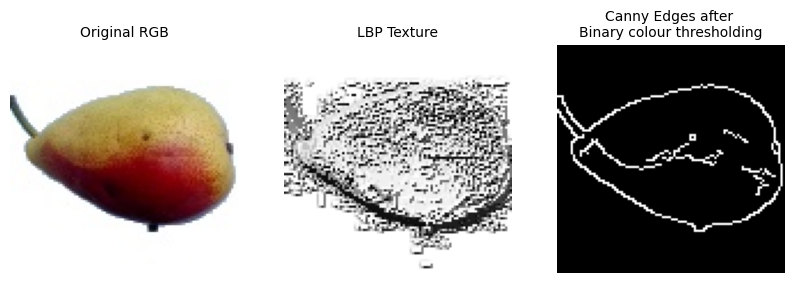



Index: 95753 , Class: Pepper Red 4
Features: {'mean_hue': np.float32(87.9969), 'std_hue': np.float32(80.04928), 'mean_sat': np.float32(167.6827), 'std_sat': np.float32(106.991325), 'mean_val': np.float32(126.3418), 'std_val': np.float32(78.52326), 'area_ratio': np.float32(0.75125), 'aspect_ratio': np.float32(0.99), 'solidity': np.float32(0.97337395), 'circularity': np.float32(0.84376556), 'hu_moment1': np.float32(0.79573977), 'hu_moment2': np.float32(4.799535)}


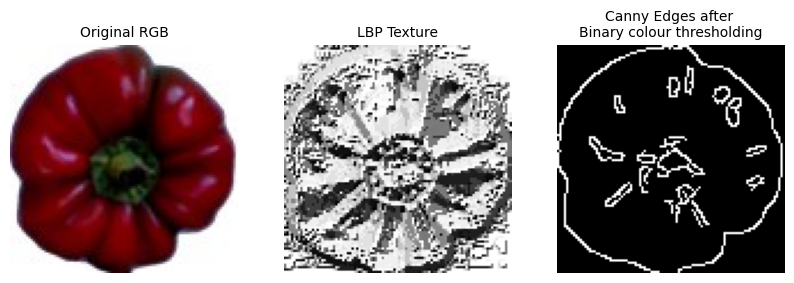



Index: 80308 , Class: Pear 10
Features: {'mean_hue': np.float32(28.4112), 'std_hue': np.float32(26.784647), 'mean_sat': np.float32(76.7558), 'std_sat': np.float32(61.417976), 'mean_val': np.float32(140.5189), 'std_val': np.float32(80.033325), 'area_ratio': np.float32(0.7224), 'aspect_ratio': np.float32(1.0638298), 'solidity': np.float32(0.9896568), 'circularity': np.float32(0.8954958), 'hu_moment1': np.float32(0.7969993), 'hu_moment2': np.float32(3.942746)}


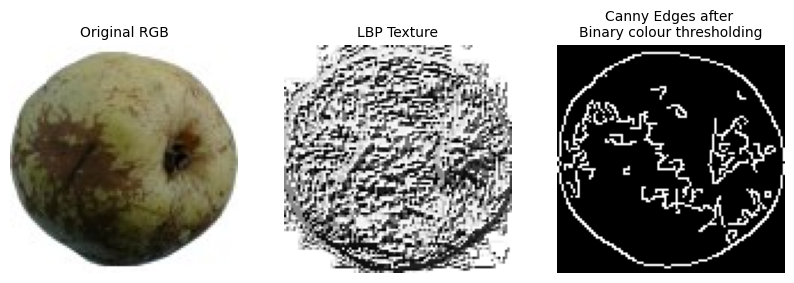



Index: 61449 , Class: Limes 1
Features: {'mean_hue': np.float32(38.9008), 'std_hue': np.float32(25.644144), 'mean_sat': np.float32(85.4616), 'std_sat': np.float32(54.354713), 'mean_val': np.float32(155.5673), 'std_val': np.float32(62.275513), 'area_ratio': np.float32(0.7627), 'aspect_ratio': np.float32(1.0204082), 'solidity': np.float32(0.98191184), 'circularity': np.float32(0.84769493), 'hu_moment1': np.float32(0.7971122), 'hu_moment2': np.float32(4.171997)}


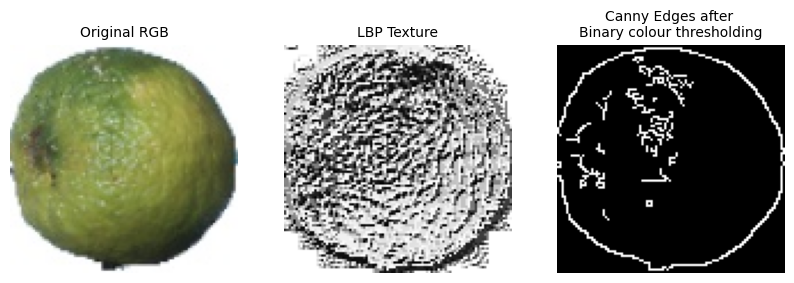



Index: 11446 , Class: Apple Pink Lady 1
Features: {'mean_hue': np.float32(32.2722), 'std_hue': np.float32(56.674606), 'mean_sat': np.float32(129.1811), 'std_sat': np.float32(89.81114), 'mean_val': np.float32(183.4057), 'std_val': np.float32(58.985607), 'area_ratio': np.float32(0.70155), 'aspect_ratio': np.float32(0.9), 'solidity': np.float32(0.96532506), 'circularity': np.float32(0.76169145), 'hu_moment1': np.float32(0.79461515), 'hu_moment2': np.float32(3.850926)}


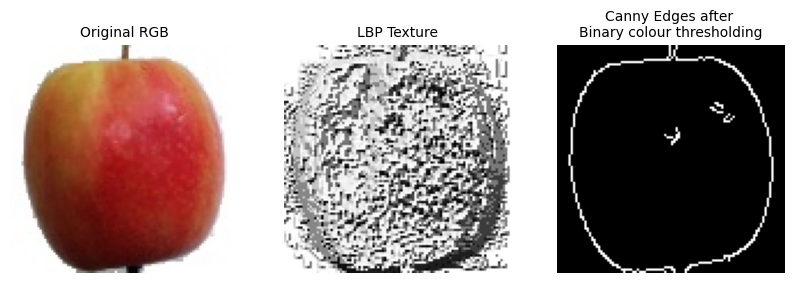

In [9]:
# --- Usage Example ---
# Using the dataloader to load 100x100 images from the dataset as 'DataLoader' objects
train_data, test_data = fruits_loader()

print("5 Random 100x100 samples from train_data of Fruits-360 dataset. Run again to see different samples\n")

# Selects random indices
indices = np.random.randint(len(train_data.dataset), size=5)

# Retrieves samples
samples = [train_data.dataset[i] for i in indices]

# Visualization
column_titles = ["Original RGB", "LBP Texture", "Canny Edges after \nBinary colour thresholding"]

for i, sample in enumerate(samples):
    # Converts tensors to numpy arrays
    img_rgb = sample['image'].permute(1, 2, 0).numpy()
    img_lbp = sample['lbp'].permute(1, 2, 0).numpy()
    img_canny = sample['canny'].permute(1, 2, 0).numpy()

    # Prints sample info and features
    print("Index:", indices[i], ", Class:", train_data.dataset.classes[train_data.dataset.labels[indices[i]]])
    print("Features:", sample['features'])
    plt.figure(figsize=(10, 30))

    # Column 0: Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title(column_titles[0], size = 10)
    plt.axis("off")

    # Column 1: LBP
    plt.subplot(1, 3, 2)
    plt.imshow(img_lbp, cmap='gray')
    plt.title(column_titles[1], size = 10)
    plt.axis("off")

    # Column 2: Canny
    plt.subplot(1, 3, 3)
    plt.imshow(img_canny, cmap='gray')
    plt.title(column_titles[2], size = 10)
    plt.axis("off")

    plt.show()
    print("\n")